In [1]:
#Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
from tqdm.notebook import trange, tqdm

In [2]:
# 32 x 32 x 1
class Encoder(nn.Module):
    def __init__(self, channels_in, ch, latent_size):
        super().__init__()
        # 16 x 16 x ch
        self.conv1 = nn.Conv2d(channels_in, ch, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(ch)
        # 8 x 8 x ch*2
        self.conv2 = nn.Conv2d(ch, ch * 2, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(ch * 2)
        # 4 x 4 x ch*4
        self.conv3 = nn.Conv2d(ch * 2, ch * 4, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(ch * 4)
        # 1 x 1 x latent_size
        self.conv_out = nn.Conv2d(ch * 4, latent_size, 4, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        return self.conv_out(x)

class Decoder(nn.Module):
    def __init__(self, channels_out, ch, latent_size):
        super().__init__()
        # 4 x 4 x ch*4
        self.conv1 = nn.ConvTranspose2d(latent_size, ch * 4, 4, 1)
        self.bn1 = nn.BatchNorm2d(ch * 4)
        # 8 x 8 x ch*2
        self.conv2 = nn.ConvTranspose2d(ch * 4, ch * 2, 3, 2, 1, 1)
        self.bn2 = nn.BatchNorm2d(ch * 2)
        # 16 x 16 x ch
        self.conv3 = nn.ConvTranspose2d(ch * 2, ch, 3, 2, 1, 1)
        self.bn3 = nn.BatchNorm2d(ch)
        # 32 x 32 x ch
        self.conv4 = nn.ConvTranspose2d(ch, ch, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(ch)
        # 32 x 32 x channels_out
        self.conv_out = nn.Conv2d(ch, channels_out, 3, 1, 1)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        return torch.tanh(self.conv_out(x))

        
        

class AutoEncoder(nn.Module):
    def __init__(self, channels, ch, latent_size):
        super().__init__()
        self.encoder = Encoder(channels, ch, latent_size)
        self.decoder = Decoder(channels, ch, latent_size)

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return x, encoding

In [3]:
batch_size = 64

lr = 1e-4

n_epoch = 10

dataset_folder = "../dataset"

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [4]:
# MNIST dataset and dataloader
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.3081,])])

train_set = Datasets.MNIST(root=dataset_folder, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=dataset_folder, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

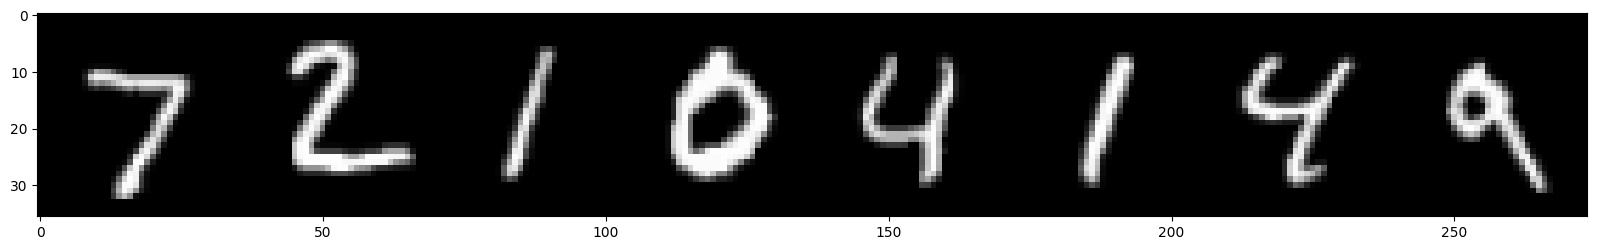

In [6]:
# Show data
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

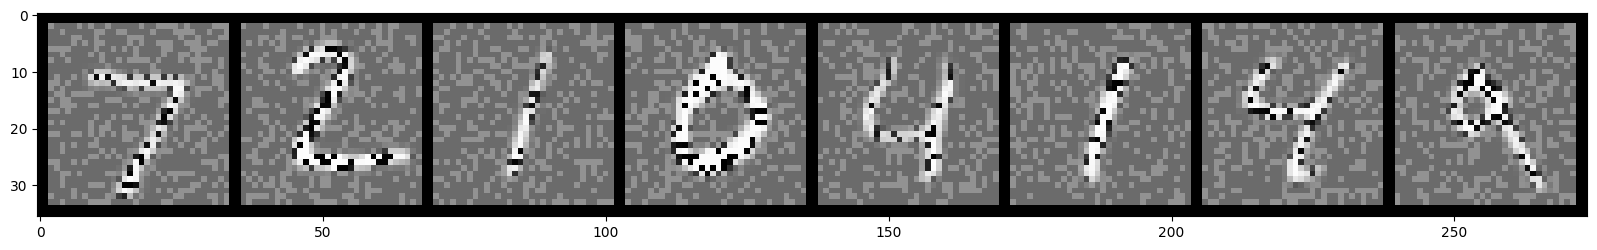

In [7]:
# Apply noise
plt.figure(figsize = (20, 10))
random_sample = torch.bernoulli(0.7 * torch.ones_like(test_images)) - 0.5
noisy_test_img = random_sample * test_images

# Show noisy data
out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [8]:
# Create a Network

autoencoder = AutoEncoder(channels=1, ch=16, latent_size=128).to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

loss_func = nn.MSELoss()

loss_log = []
train_loss = 0

In [9]:
pbar = trange(0, n_epoch, leave=False, desc="Epoch")
for i in pbar:
    pbar.set_postfix_str("Loss: %.4f" % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        image = data[0].to(device)
        
        random_sample = torch.bernoulli(0.7 * torch.ones_like(image)) - 0.5
        noisy_img = random_sample * image
        
        recon_data, _ = autoencoder(noisy_img)
        
        loss = loss_func(recon_data, image)
        
        loss_log.append(loss.item())
        train_loss += loss.item()
        
        autoencoder.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

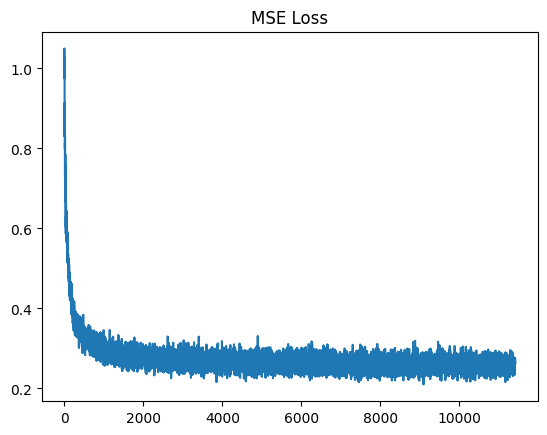

In [27]:
_ = plt.plot(loss_log)
_ = plt.title("MSE Loss")

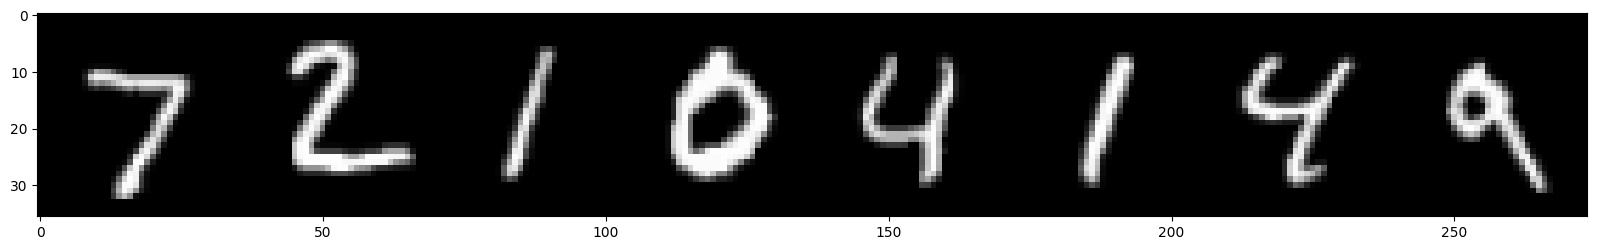

In [10]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

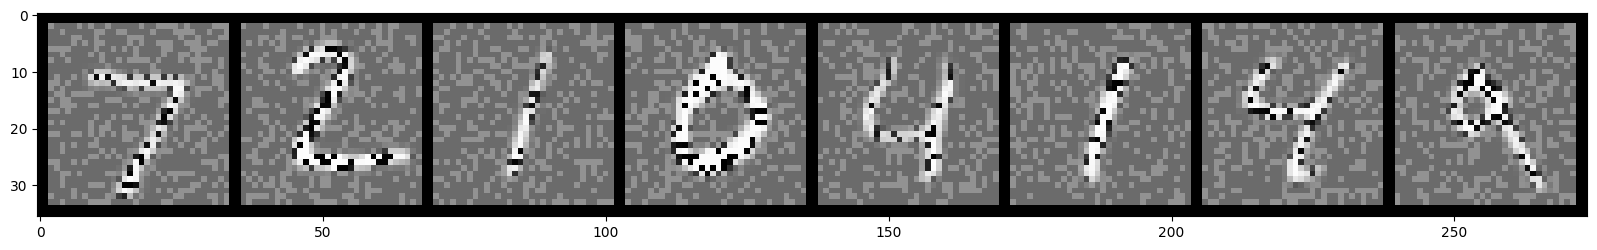

In [11]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [12]:
autoencoder = AutoEncoder(channels=1, ch=16, latent_size=128).to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

autoencoder.load_state_dict(torch.load("./lab1.pth", weights_only=True))
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_out): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

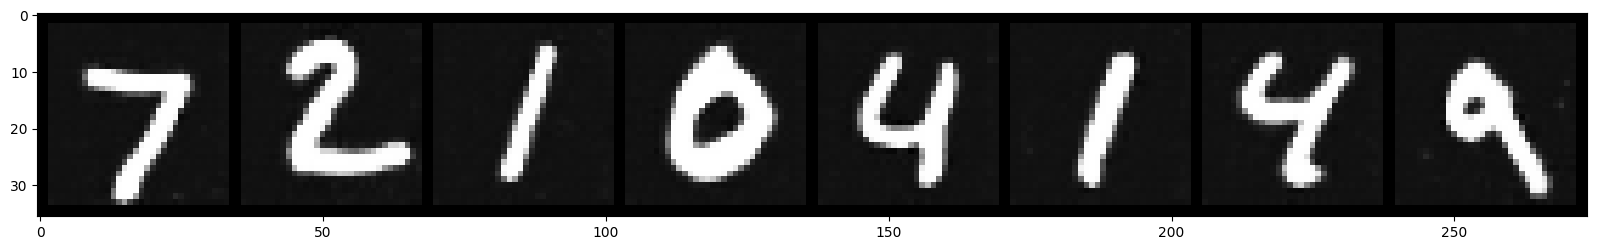

In [13]:
plt.figure(figsize = (20,10))
recon_data, encoding = autoencoder(noisy_test_img.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
torch.save(autoencoder.state_dict(), "./lab1.pth")